## TP RBM

Implementation of a Resctricted Boltzmann Machine. You will need to code the following functions
  * **sigmoid** : return the sigmoid function
  * **SampleHiddens** : given a RBM (weight matrix and local biases), and a set of visible configuration, return new samples for the hidden nodes according to $p(\vec{\sigma}|\vec{s})$
  * **SampleVisibles** : given a RBM (weight matrix and local biases), and a set of hidden configuration, return new samples for the visible nodes according to $p(\vec{s}|\vec{\sigma})$
  * **Sampling** : given a RBM and a set of visible configurations, return a set of samples after t steps. It will be important to return the set of visible/hidden configuration AND the magnetisations
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Loading artificial dataset !
X = np.genfromtxt('art4clus.d')
u,s,v = np.linalg.svd(X/X.shape[1]**0.5)
Xsc = np.matmul(X.T,u)

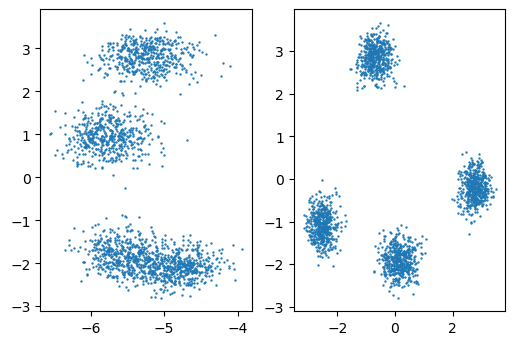

In [5]:
f,ax = plt.subplots(1,2,dpi=100)
ax[0].scatter(Xsc[:,0],Xsc[:,1],s=0.5)
ax[1].scatter(Xsc[:,2],Xsc[:,3],s=0.5)

In [18]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [19]:
# X is Nv X M
# W is Nh x Nv
def SampleHiddens(X,W,b):
    mh = sigmoid(np.matmul(W,X) + b.reshape(W.shape[0],1))
    h = (np.random.random(mh.shape) < mh)*1
    return h,mh

In [3]:
# H is Nh X M
# W is Nh x Nv
def SampleVisibles(H,W,a):
    mv = sigmoid(np.matmul(W.T,H) + a.reshape(W.shape[1],1))
    v = (np.random.random(mv.shape) < mv)*1
    return v,mv

In [4]:
def GetAv(Xchain,W,a,b,it_max=20):
    v_init = np.copy(Xchain)
    h,mh_pos = SampleHiddens(v_init,W,b)
    v,mv = SampleVisibles(h,W,a)
    
    #h,mh =  = SampleHiddens(v,W,b)
    #v,mv = SampleVisibles(h,W,a)
    
    for t in range(1,it_max):
        h,mh = SampleHiddens(v,W,b)
        v,mv = SampleVisibles(h,W,a)
        
    return v_init,mh_pos,v,h

In [5]:
def Sampling(X,W,a,b,it_max=20):
    h,mh = SampleHiddens(X,W,b)
    v,mv = SampleVisibles(h,W,a)
    
    h,mh = SampleHiddens(v,W,b)
    v,mv = SampleVisibles(h,W,a)
    
    for t in range(it_max):
        h,mh = SampleHiddens(v,W,b)
        v,mv = SampleVisibles(h,W,a)
        
    return v,mv,h,mh

In [6]:
def updateWeights(v_pos,h_pos,v_neg,h_neg,W,a,b,lr):
    W += lr*(np.matmul(h_pos,v_pos.T) - np.matmul(h_neg,v_neg.T)) / v_pos.shape[1]
    a += lr*(np.sum(v_pos,axis=1) - np.sum(v_neg,axis=1)) / v_pos.shape[1]
    b += lr*(np.sum(h_pos,axis=1) - np.sum(h_neg,axis=1)) / h_pos.shape[1]

In [7]:
def updateFields(v_pos,h_pos,v_neg,h_neg,W,a,b,lr):
    a += lr*(np.sum(v_pos,axis=1) - np.sum(v_neg,axis=1)) / v_pos.shape[1]
    b += lr*(np.sum(h_pos,axis=1) - np.sum(h_neg,axis=1)) / h_pos.shape[1]
    


In [8]:
def fit_batch(X,Xchain,W,a,b,lr,it_max=20):
    _, h_pos = SampleHiddens(X,W,b)
    _,_,Xchain,h = GetAv(Xchain,W,a,b,it_max=it_max)
    updateWeights(X,h_pos,Xchain,h,W,a,b,lr)
    return Xchain

In [10]:
# implement batches
def getMiniBatches(X,m,bs):
    return X[:,m*bs:(m+1)*bs]

In [11]:
def Energy(V,H,W,a,b):
    E = np.multiply(np.matmul(H.T,W), V.T) + np.matmul(V.T,a.reshape(W.shape[1])).reshape(V.shape[1],1) + np.matmul(H.T,b.reshape(W.shape[0])).reshape(V.shape[1],1)
    return -np.sum(E,axis=1)/(W.shape[0]+W.shape[1])

In [12]:
def SamplingMF(X,W,a,b,it_max=10):
    _,mh = SampleHiddens(X,W,b)
    _,mv = SampleVisibles(mh,W,a)

    for t in range(it_max):
        _,mh = SampleHiddens(mv,W,b)
        _,mv = SampleVisibles(mh,W,a)
        
    return mv,mh

In [13]:
def Entropy(mv,mh):
    Sv = -( mv*np.log(mv) + (1-mv)*np.log(1-mv) )
    Sh = -( mh*np.log(mh) + (1-mh)*np.log(1-mh) )
    return (np.sum(Sv,axis=0)+np.sum(Sh,axis=0)).T

In [14]:
def FreeEnergy(mv,mh,W,a,b):
    S = Entropy(mv,mh)
    E = Energy(mv,mh,W,a,b)
    return E-S

In [46]:
# init
Nv = X.shape[0]
Nh = 50
bs = 25
NB = int(X.shape[1]/bs)
W = np.random.normal(0,1e-4,size=(Nh,Nv))
a = np.zeros(Nv)
b = np.zeros(Nh)
Xchain = np.random.random((Nv,bs))
lr = 0.05
t_max = 100

for t in range(t_max):
    print(t)
    for m in range(NB):
        Xb = getMiniBatches(X,m,bs)
        Xchain = fit_batch(Xb,Xchain,W,a,b,lr,it_max=20)

#for m in range(NB):
#    Xb = getMiniBatches(X,m,bs)
#    Xchain = fit_batch_fields(Xb,Xchain,W,a,b,lr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [47]:
VisInit = np.random.random((Nv,2000))
Xgen,_,_,_ = Sampling(VisInit,W,a,b,it_max=1000)

In [53]:
u,s,v = np.linalg.svd(W)
Xsc = np.matmul(X.T,v)
Xsc_gen = np.matmul(Xgen.T,v)

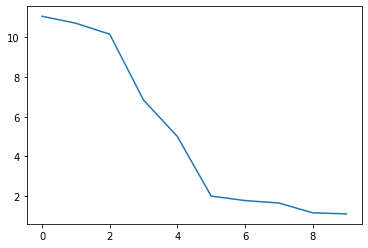

In [49]:
plt.plot(s[:10])

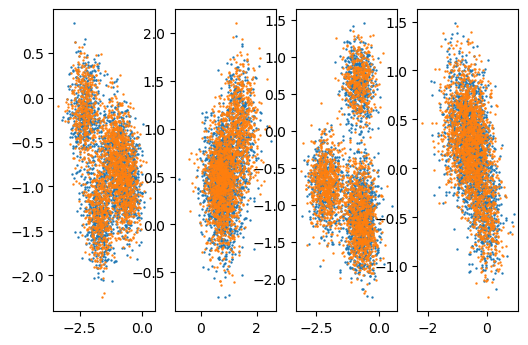

In [58]:
f,ax = plt.subplots(1,4,dpi=100)
ax[0].scatter(Xsc[:,0],Xsc[:,1],s=0.5)
ax[1].scatter(Xsc[:,2],Xsc[:,3],s=0.5)
ax[2].scatter(Xsc[:,4],Xsc[:,5],s=0.5)
ax[3].scatter(Xsc[:,6],Xsc[:,7],s=0.5)
ax[0].scatter(Xsc_gen[:,0],Xsc_gen[:,1],s=0.5)
ax[1].scatter(Xsc_gen[:,2],Xsc_gen[:,3],s=0.5)
ax[2].scatter(Xsc_gen[:,4],Xsc_gen[:,5],s=0.5)
ax[3].scatter(Xsc_gen[:,6],Xsc_gen[:,7],s=0.5)

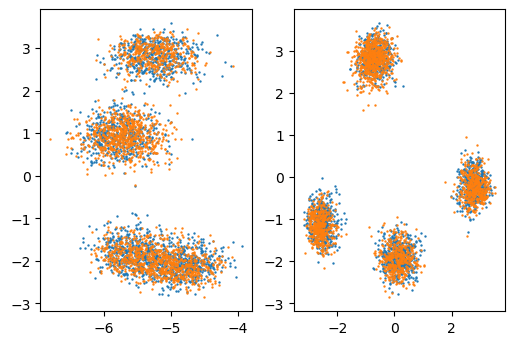

In [52]:
ux,sx,vx = np.linalg.svd(X/X.shape[1]**0.5)

Xsc = np.matmul(X.T,ux)
Xsc_gen = np.matmul(Xgen.T,ux)

f,ax = plt.subplots(1,2,dpi=100)
ax[0].scatter(Xsc[:,0],Xsc[:,1],s=0.5)
ax[1].scatter(Xsc[:,2],Xsc[:,3],s=0.5)
ax[0].scatter(Xsc_gen[:,0],Xsc_gen[:,1],s=0.5)
ax[1].scatter(Xsc_gen[:,2],Xsc_gen[:,3],s=0.5)

In [15]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as pp

f = gzip.open('../../M1Pro-ML/mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, _, _ = p

X = train_set[0][:10000,:].T
# we can discretize if needed

In [20]:
# init
Nv = X.shape[0]
Nh = 200
bs = 25
NB = int(X.shape[1]/bs)
W = np.random.normal(0,1e-4,size=(Nh,Nv))
a = np.zeros(Nv)
b = np.zeros(Nh)
Xchain = np.random.random((Nv,bs))
lr = 0.05
t_max = 50

for t in range(t_max):
    print(t)
    for m in range(NB):
        Xb = getMiniBatches(X,m,bs)
        Xchain = np.random.random((Nv,bs))
        Xchain = fit_batch(Xb,Xchain,W,a,b,lr,it_max=20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [21]:
u,s,v = np.linalg.svd(W)

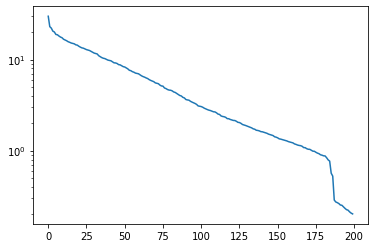

In [22]:
import matplotlib.pyplot as plt
plt.semilogy(s)

Test of sampling

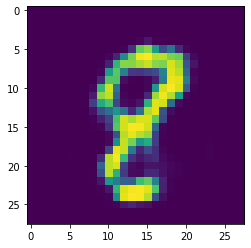

In [35]:
v = np.random.random((Nv,1))
v,mv,h,mh = Sampling(v,W,a,b,it_max=20)
plt.imshow(mv.reshape(28,28))

Visualization of the weight matrix

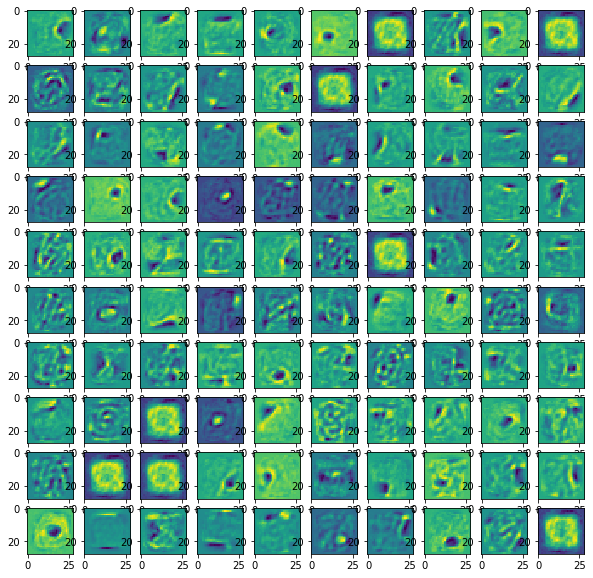

In [25]:
f,ax = plt.subplots(10,10,figsize=(10,10))
idx = 0
for i1 in range(10):
    for i2 in range(10):
        ax[i1,i2].imshow(W[idx,:].reshape(28,28))
        idx += 1

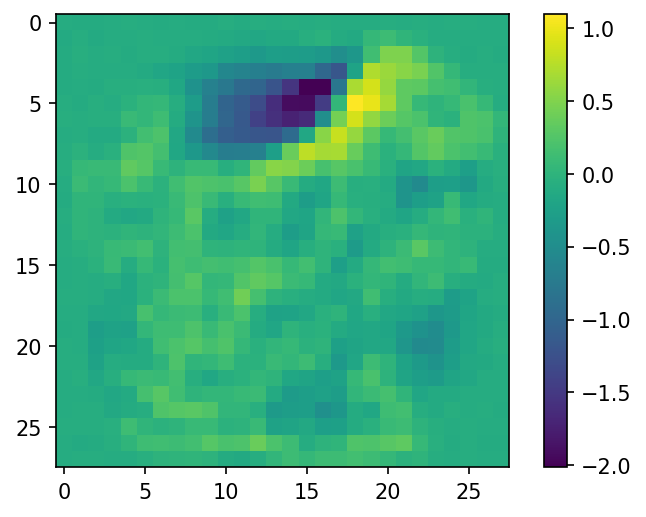

In [40]:
plt.figure(dpi=150)
plt.imshow(W[2,:].reshape(28,28))
plt.colorbar()

(array([1.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00, 6.0000e+00,
        4.0000e+00, 9.0000e+00, 1.1000e+01, 2.0000e+01, 1.5000e+01,
        1.8000e+01, 3.7000e+01, 4.0000e+01, 4.6000e+01, 4.2000e+01,
        4.6000e+01, 7.9000e+01, 7.9000e+01, 8.6000e+01, 8.9000e+01,
        1.1000e+02, 1.4100e+02, 1.6000e+02, 1.8800e+02, 1.9300e+02,
        2.3900e+02, 2.3700e+02, 2.6100e+02, 2.9800e+02, 3.7200e+02,
        4.2200e+02, 4.8500e+02, 6.0200e+02, 7.1000e+02, 8.3500e+02,
        1.0280e+03, 1.2840e+03, 1.7380e+03, 2.2690e+03, 3.1690e+03,
        4.4050e+03, 6.4400e+03, 9.2430e+03, 1.3965e+04, 2.3520e+04,
        4.5431e+04, 8.6972e+04, 6.7553e+04, 3.1787e+04, 2.4503e+04,
        1.8590e+04, 1.3287e+04, 9.0620e+03, 6.3750e+03, 4.1440e+03,
        2.7900e+03, 2.0070e+03, 1.3820e+03, 1.1090e+03, 8.2500e+02,
        6.2500e+02, 4.9400e+02, 3.7400e+02, 2.8300e+02, 2.5300e+02,
        1.6900e+02, 1.3000e+02, 1.0700e+02, 1.2500e+02, 8.9000e+01,
        6.2000e+01, 7.6000e+01, 5.9000e+01, 5.60

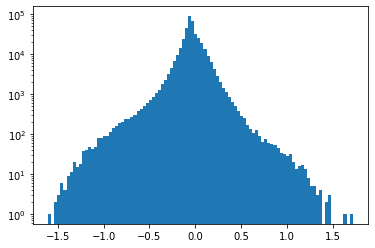

In [379]:
plt.hist(W.reshape(Nv*Nh),bins=100,log=True)

Sampling many configurations

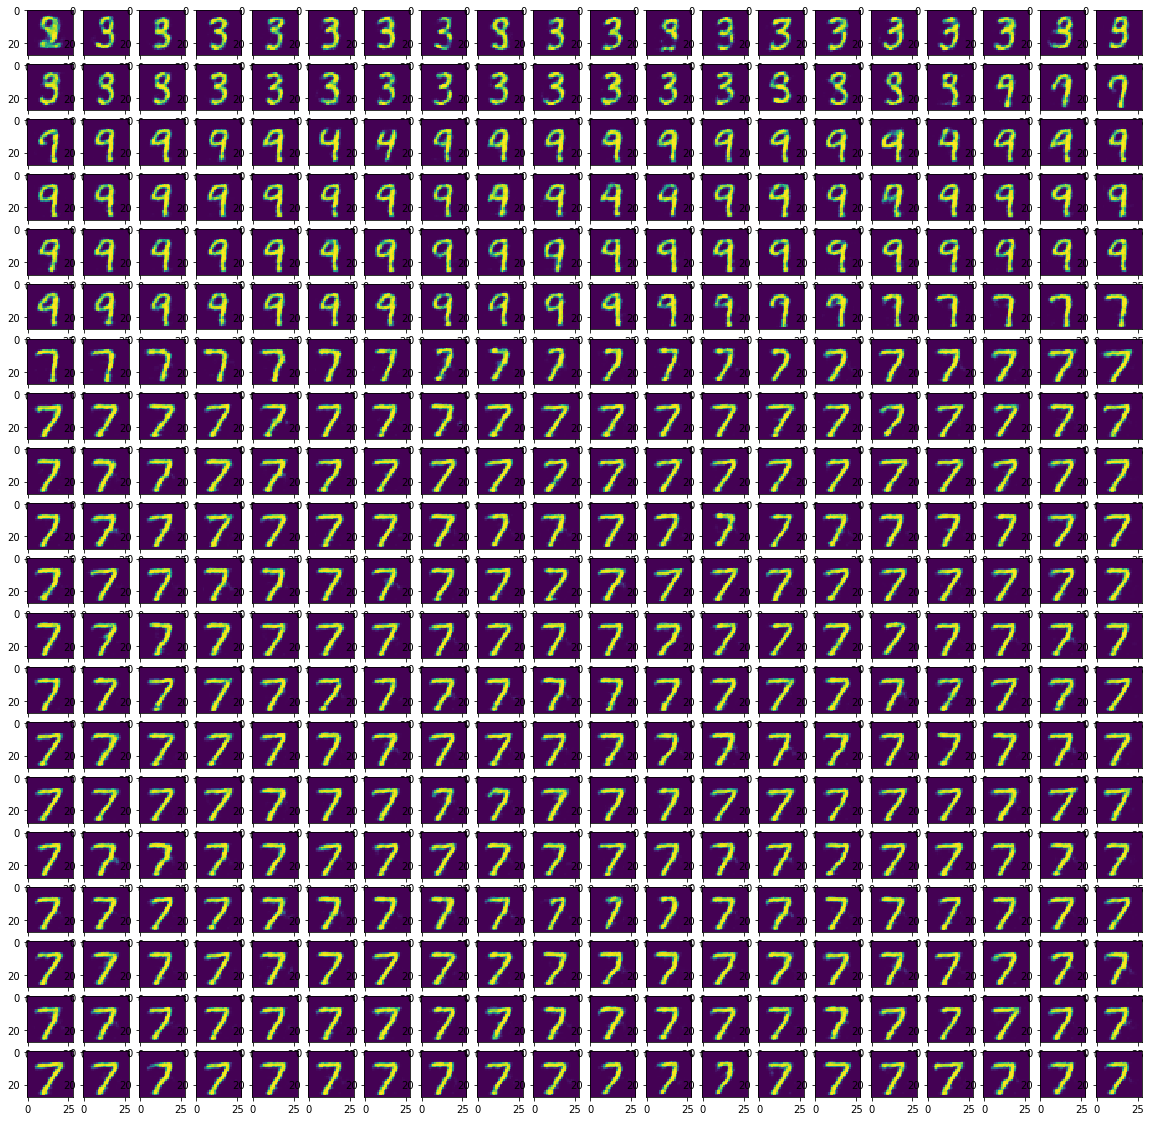

In [26]:
v = np.random.random((Nv,1))
f,ax = plt.subplots(20,20,figsize=(20,20))
for i1 in range(20):
    for i2 in range(20):
        v,mv,h,mh = Sampling(v,W,a,b,it_max=10)
        ax[i1,i2].imshow(mv.reshape(28,28))

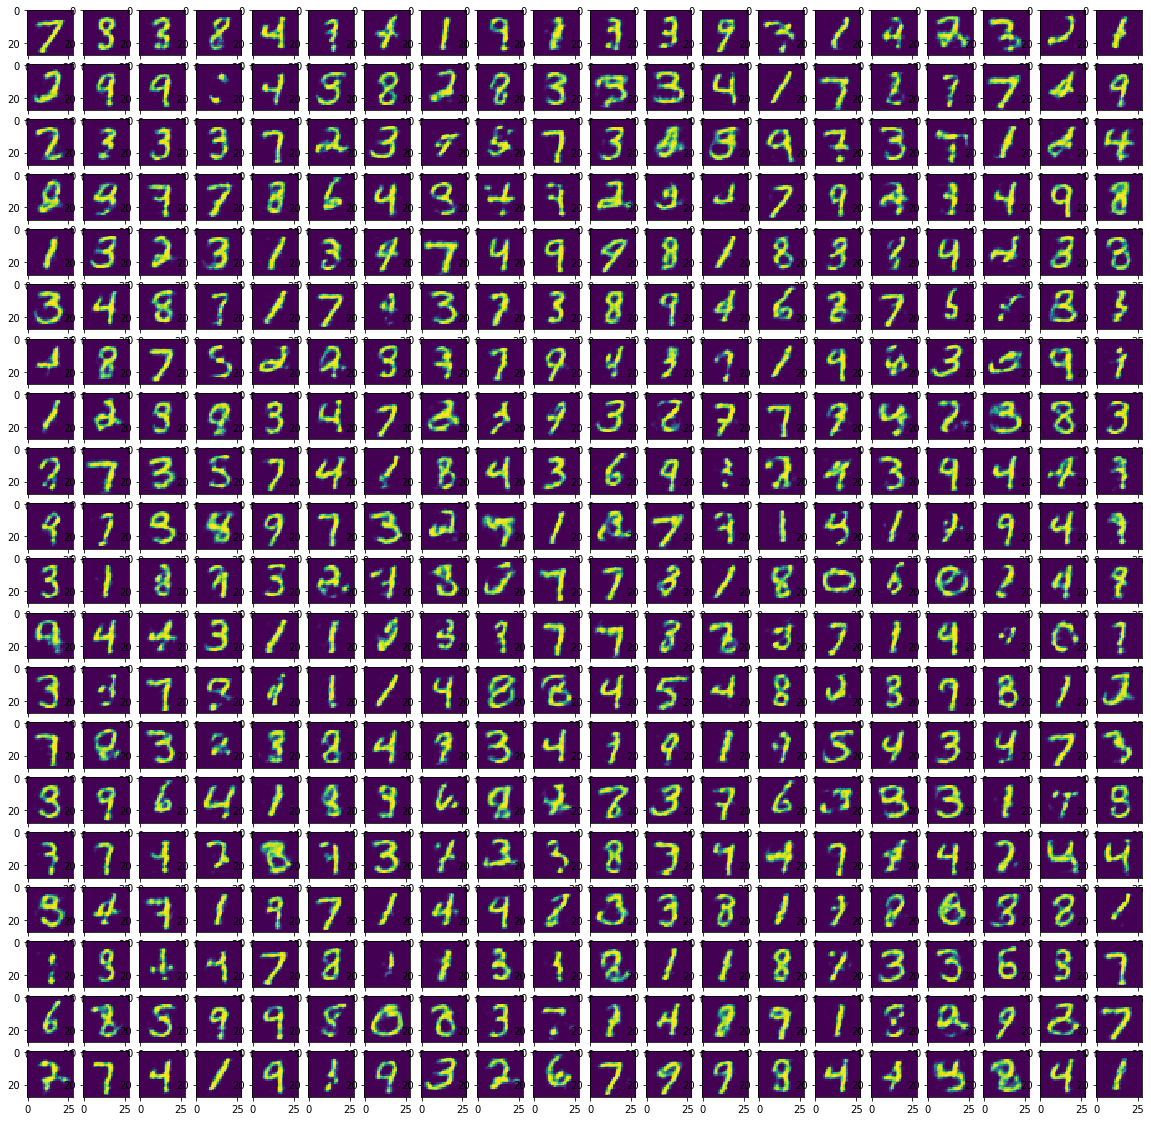

In [27]:
v = np.random.random((Nv,400))
v,mv,h,mh = Sampling(v,W,a,b,it_max=20)
f,ax = plt.subplots(20,20,figsize=(20,20))
idx = 0
for i1 in range(20):
    for i2 in range(20):
        ax[i1,i2].imshow(mv[:,idx].reshape(28,28))
        idx += 1

Test for mean-field fixed points